What Deck Should i bring to my next tournament?

In [1]:
# Import libraries
import time
from time import sleep
import numpy as np
from string import punctuation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from pathlib import Path
# import for creating new directory to write to
import os

#import for getting arguments from the command line
import argparse

#USed to get variables from each folder
import importlib.util

In [2]:
from scraper import *

In [3]:
def decklist_filter(decklist: pd.DataFrame, participants: pd.DataFrame, str_list: list):
    """Input two data frames and a list of strings. The beggining of the list are cards that define the archetype.
    The Last item in the list will be the name you wish to use to rename all lists that fall in this filter."""
    loop_deck = decklist.copy()
    loop_participants = participants.copy()
    for i in loop_deck[(loop_deck['Card Name'] == str_list[0]) | (loop_deck['Card Name'] == str_list[1]) | (loop_deck['Card Name'] == str_list[2])].groupby('Profile Name').size().index:
        # print(f"The filter this loop is: {i}")
        if loop_deck[(loop_deck['Card Name'] == str_list[0]) | (loop_deck['Card Name'] == str_list[1]) | (loop_deck['Card Name'] == str_list[2])].groupby('Profile Name').size()[i] == len(str_list) - 1:
            loop_deck.loc[(loop_deck["Profile Name"] == i),"Deck Name"] = str_list[3]
            loop_participants.loc[loop_participants["Player Profile Name"] == i,"Deck Name"] = str_list[3]
    return loop_deck, loop_participants

In [4]:
# Variable Definitions
directory = f"{os.getcwd()}/{os.listdir()[1]}"
location = [ele for ele in os.listdir(f'{directory}')]

complete_decklists = pd.DataFrame()
complete_rounds = pd.DataFrame()
complete_participants = pd.DataFrame()


In [5]:
#Loops through the data directories and saves them to dataframes
for f in os.listdir(f'{directory}'):    #Lists each file tournament folder in the data
    # #Import local variables for each directory
    # spec = importlib.util.spec_from_file_location("variables", f"{directory}/{f}/{f}_variables.py")
    # variables = importlib.util.module_from_spec(spec)
    # spec.loader.exec_module(variables)
    # url = variables.URL
    # data_directory = variables.DATA_DIRECTORY
    # #go to web page
    # sleep(0.15)
    # browser.get(url)

    # if f == os.listdir(f'{directory}')[0]: # Waits for Cookie button to appear then clicks it
    #     try:
    #         wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#necessaryOnlyButton")))
    #     except:
    #         # browser.quit()
    #         print("No Button Exists")
    #     else:
    #         browser.find_element(By.CSS_SELECTOR, "#necessaryOnlyButton").click()

    # # #PT Atlanta did not have the final round posted so you must slect the semifinals
    # # if "pt_atlanta_09_26_2025" == f:
    # #     try:
    # #         wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, '#standings-round-selector-container > button:nth-child(18)')))
    # #     except:
    # #         print("pt_atlanta_09_26_2025" == f)
    # #     else:
    # #         browser.find_element(By.CSS_SELECTOR, '#standings-round-selector-container > button:nth-child(18)').click()

    # #Reads the results of the Tournament and stores them in a csv or reads from an already made csv
    # try:
    #     #Tests if a .csv for this section exits
    #     check_file_location(f"{data_directory}/participant_df.csv")
    # except:
    #     #Reads the results of the tournament
    #     participant_df = set_tournament_participants(url)
    #     # Store in a csv
    #     participant_df.to_csv(f"{data_directory}/participant_df.csv", index_label=False)
    # else:   
    #     # Load from csv
    #     participant_df = pd.read_csv(f"{data_directory}/participant_df.csv")

    # #Pull data from each players deck page
    # try:
    #     #Tests if decklists or rounds have been saved yet
    #     check_file_location(f"{data_directory}/complete_decklists.csv")
    #     check_file_location(f"{data_directory}/all_round_results.csv")
    # except:
    #     #Set match results and decklist variables
    #     decks_and_rounds = set_match_results_and_decklists(participant_df, data_directory)
    #     match_result_df = remove_duplicate_matches(decks_and_rounds[0])
    #     complete_decklists = decks_and_rounds[1]
    #     # Save to .csv
    #     match_result_df.to_csv(f"{data_directory}/all_round_results.csv", index_label=False)
    #     complete_decklists.to_csv(f"{data_directory}/complete_decklists.csv", index_label=False)
    # else:
    #     # Read from .csv
    #     match_result_df = pd.read_csv(f"{data_directory}/all_round_results.csv")
    #     complete_decklists = pd.read_csv(f"{data_directory}/complete_decklists.csv")

    for data_file in os.listdir(f'{directory}/{f}/data/'):  #lists all files in the data directory of that tournament
            storage_df = pd.read_csv(f"{directory}/{f}/data/{data_file}")
            try: #checks if there is a location column in the file loaded from the dataframe
                storage_df['Location']
            except: #will add location and resave the file
                storage_df["Location"] = f
                storage_df.to_csv(f"{directory}/{f}/data/{data_file}", index_label=False)
            if data_file == 'participant_df.csv':
                try: #checks if the variable is empty, if it is, set it equal to the current file
                    complete_participants = pd.concat([complete_participants, storage_df])
                except:
                    complete_participants = storage_df
            if data_file == 'all_round_results.csv':
                try: #checks if the variable is empty, if it is, set it equal to the current file
                    complete_rounds = pd.concat([complete_rounds, storage_df])
                except:
                    complete_rounds = storage_df
            if data_file == 'complete_decklists.csv':
                try: #checks if the variable is empty, if it is, set it equal to the current file
                    complete_decklists = pd.concat([complete_decklists, storage_df])
                except:
                    complete_decklists = storage_df

In [6]:
browser.quit()

In [7]:

#List of all deck strategy filters
archetype_filter_list = [["Blighted Agent","Glistener Elf","Scale Up","Infect"],
               ["Orim's Chant","Narset, Parter of Veils","Teferi, Time Raveler","Azorius Control"],
               ["Wrenn and Six","Phlage, Titan of Fire's Fury","Teferi, Time Raveler","Jeskai Control"],
               ["Kappa Cannoneer","Pinnacle Emissary","Thoughtcast","Izzet Affinity"],
               ["Karn, the Great Creator","Devourer of Destiny","Urza's Tower",'Colorless Tron'],
               ["Psychic Frog","Murktide Regent","Counterspell",'Dimir Murktide'],
               ["Agatha's Soul Cauldron","Blade of the Bloodchief","Basking Broodscale",'Cauldron Broodscale Combo'],
               ["Kozilek's Command","Blade of the Bloodchief","Basking Broodscale",'Eldrazi Broodscale Combo'],
               ["Living End","Shardless Agent","Ardent Plea",'Bant Living End'],
               ["Psychic Frog","Phelia, Exuberant Shepherd","Quantum Riddler",'Esper Blink'],
               ["Quantum Riddler","Phelia, Exuberant Shepherd","Ragavan, Nimble Pilferer",'Jeskai Blink'],
               ["Faithful Mending","Atraxa, Grand Unifier","Goryo's Vengeance","Esper Goryo's Vengeance"],
               ['Territorial Kavu',"Scion of Draco","Leyline of the Guildpact",'Domain Zoo'],
               ["Ajani, Nacatl Pariah // Ajani, Nacatl Avenger","Phlage, Titan of Fire's Fury",'Ocelot Pride','Boros Energy'],
               ["Forest","Amulet of Vigor","Primeval Titan",'Amulet Titan'],
               ["Birthing Ritual","Abhorrent Oculus","Flare of Denial",'Simic Birthing Ritual'],
               ["Mutagenic Growth","Slickshot Show-Off","Lava Dart",'Izzet Prowess'],
               ["Tameshi, Reality Architect","Goblin Charbelcher","Sea Gate Restoration // Sea Gate, Reborn",'Mono-Blue Belcher'],
               ["Ral, Monsoon Mage // Ral, Leyline Prodigy","Ruby Medallion","Desperate Ritual", "Ruby Storm"],
               ["Omnath, Locus of Creation","Birthing Ritual","Solitude","4 Color Birthing Ritual"],
               ["Samwise Gamgee","Cauldron Familiar","Birthing Ritual", "Abzan Samwise Combo"],
               ["Guide of Souls","Starfield Shepherd", "Quantum Riddler", "Azorius Energy"],
               ["Living End","Shardless Agent","Street Wraith","Sultai Living End"],
               ["Hollow One","Faithless Looting","Burning Inquiry","Hallow One"],
               ["Winota, Joiner of Forces","Blade Historian", "Phelia, Exuberant Shepard", "Winota"],
               ["Omnath, Locus of Creation","Risen Reef","Endurance", "Risen Reef"],
               ["Overlord of the Balemurk","Phelia, Exuberant Shepherd","Flickerwisp", "Orzhov Blink"],
               ["Allosaurus Rider","Neoform","Atraxa, Grand Unifier","Neoform"],
               ["Harbinger of the Seas","Flare of Denial","Master of the Pearl Trident","Merfolk"]]

In [8]:
#Deck cleaning for the complete list of tournaments
for cards in archetype_filter_list:
    for tournament in location:
        complete_decklists[complete_decklists["Location"] == tournament], complete_participants[complete_participants["Location"] == tournament] = decklist_filter(complete_decklists[complete_decklists["Location"] == tournament], complete_participants[complete_participants['Location'] == tournament], cards)

# set variables for only rcq baltimore
just_baltimore_participants = complete_participants[complete_participants['Location'] == 'rcq_baltimore_10_26_2025'].copy()
just_baltimore_decks = complete_decklists[complete_decklists['Location'] == 'rcq_baltimore_10_26_2025'].copy()
just_baltimore_rounds = complete_rounds[complete_rounds['Location'] == 'rcq_baltimore_10_26_2025'].copy()


In [9]:
baltimore_win_percentages_overall = pd.DataFrame(columns=["Deck Name", "Wins", "Loses", "Draws", "Number of Player", "Total Games", "Win Percentage"])
baltimore_match_record_by_deck = just_baltimore_participants[['Deck Name','Match Record', 'Match Total']].copy()
baltimore_match_record_by_deck["Match Record"] = baltimore_match_record_by_deck["Match Record"].apply(lambda x: x.replace("[", "").replace("]","").split(","))
# Get all deck names
deck_names = baltimore_match_record_by_deck.groupby("Deck Name").sum().index
for ele in deck_names: #Fills out the baltimore_win_percentages_overall using baltimore_match_record_by_deck
    baltimore_win_percentages_overall.loc[len(baltimore_win_percentages_overall)] = ele
    baltimore_win_percentages_overall.loc[baltimore_win_percentages_overall['Deck Name'] == ele, "Wins"] = baltimore_match_record_by_deck[baltimore_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[0].astype(int).sum()
    baltimore_win_percentages_overall.loc[baltimore_win_percentages_overall['Deck Name'] == ele, "Total Games"] = baltimore_match_record_by_deck[baltimore_match_record_by_deck['Deck Name'] == ele]["Match Total"].sum()
    baltimore_win_percentages_overall.loc[baltimore_win_percentages_overall['Deck Name'] == ele, "Loses"] = baltimore_match_record_by_deck[baltimore_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[1].astype(int).sum()
    baltimore_win_percentages_overall.loc[baltimore_win_percentages_overall['Deck Name'] == ele, "Draws"] = baltimore_match_record_by_deck[baltimore_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[2].astype(int).sum()
    baltimore_win_percentages_overall.loc[baltimore_win_percentages_overall['Deck Name'] == ele, 'Number of Player'] = baltimore_match_record_by_deck.groupby("Deck Name").size()[ele]
baltimore_win_percentages_overall["Win Percentage"] = ((baltimore_win_percentages_overall['Wins'] + 0.5 * baltimore_win_percentages_overall['Draws']) / baltimore_win_percentages_overall['Total Games'])*100



In [10]:
def convert_stringlist_to_numeric(numbers: str):
    numbers =  numbers.replace("[", "").replace("]","").split(",")
    loop_list = [int(ele) for ele in numbers]
    return loop_list
#Works for all tournaments
win_percentages_overall = pd.DataFrame(columns=["Deck Name", "Wins", "Loses", "Draws", "Number of Player", "Total Games", "Win Percentage"])
complete_match_record_by_deck = complete_participants[['Deck Name','Match Record', 'Match Total']].copy()
complete_match_record_by_deck["Match Record"] = complete_match_record_by_deck["Match Record"].apply(convert_stringlist_to_numeric)
complete_wins_per_deck = pd.DataFrame(columns=range(10000))
# Get all deck names
deck_names = complete_match_record_by_deck.groupby("Deck Name").sum().index
for ele in deck_names: #Fills out the win_percentages_overall using complete_match_record_by_deck
    win_percentages_overall.loc[len(win_percentages_overall)] = ele
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Wins"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[0].astype(int).sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Total Games"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Total"].sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Loses"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[1].astype(int).sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, "Draws"] = complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[2].astype(int).sum()
    win_percentages_overall.loc[win_percentages_overall['Deck Name'] == ele, 'Number of Player'] = complete_match_record_by_deck.groupby("Deck Name").size()[ele]
    complete_wins_per_deck.loc[ele] = pd.Series(complete_match_record_by_deck[complete_match_record_by_deck['Deck Name'] == ele]["Match Record"].str[0].values, name = ele)
win_percentages_overall["Win Percentage"] = ((win_percentages_overall['Wins'] + 0.5 * win_percentages_overall['Draws']) / win_percentages_overall['Total Games'])*100
complete_wins_per_deck.dropna(axis=1,inplace=True, how="all")
complete_wins_per_deck = complete_wins_per_deck.T


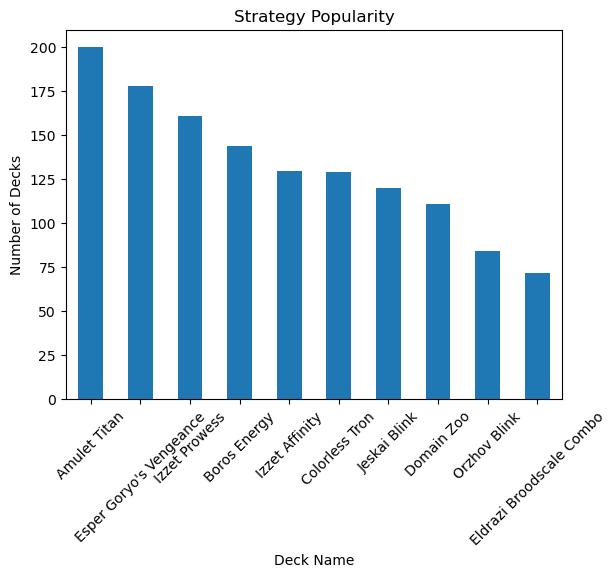

In [ ]:
# for ele in location:    #Diplays the top 20 most popular decks at each tournament
#     complete_participants[complete_participants["Location"] == ele].groupby("Deck Name").size().sort_values(ascending=False).head(10).plot.bar()
#     plt.title(ele)
#     plt.show()
most_popular_decks = complete_participants.groupby("Deck Name").size().sort_values(ascending=False).head(10).index
complete_participants.groupby("Deck Name").size().sort_values(ascending=False).head(10).plot.bar(rot=45).set_ylabel("Number of Decks")
plt.title('Strategy Popularity')
plt.show()
#This shows how How popular a deck has been over the last 3 months.

Text(0.5, 1.0, 'Strategy Win Rate')

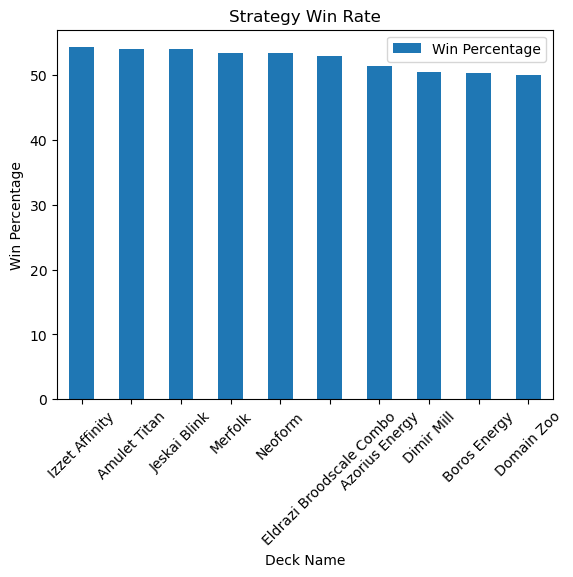

In [ ]:
# Bar plot for win percentage
# baltimore_win_percentages_overall[baltimore_win_percentages_overall["Total Games"] > 6].sort_values(by="Win Percentage", ascending=False).plot.bar(x="Deck Name", y="Win Percentage").set_ylabel("Win Percentage")
#For everything
highest_winrate_decks = win_percentages_overall[(win_percentages_overall["Total Games"] > 60)].sort_values(by="Win Percentage", ascending=False)['Deck Name'].head(10).values
win_percentages_overall[(win_percentages_overall["Total Games"] > 60)].sort_values(by="Win Percentage", ascending=False).head(10).plot.bar(x="Deck Name", y="Win Percentage",rot=45).set_ylabel("Win Percentage")
plt.title('Strategy Win Rate')
# this is the top 10 win percentages of decks. Note where the most popular decks are.

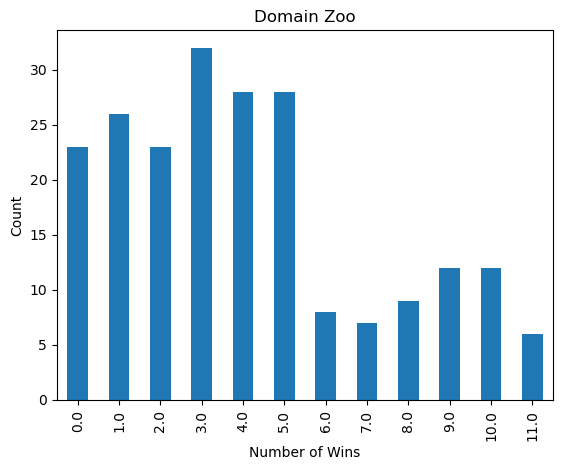

In [ ]:
# fig, ax = plt.subplots(layout=(2,5))
for deck in highest_winrate_decks:
    complete_wins_per_deck[deck].value_counts().sort_index().plot.bar(subplots=True)
    plt.ylabel("Count")
    plt.xlabel("Number of Wins")
    plt.title(deck)
    plt.show()

Text(0.5, 1.0, 'Distribution of Wins')

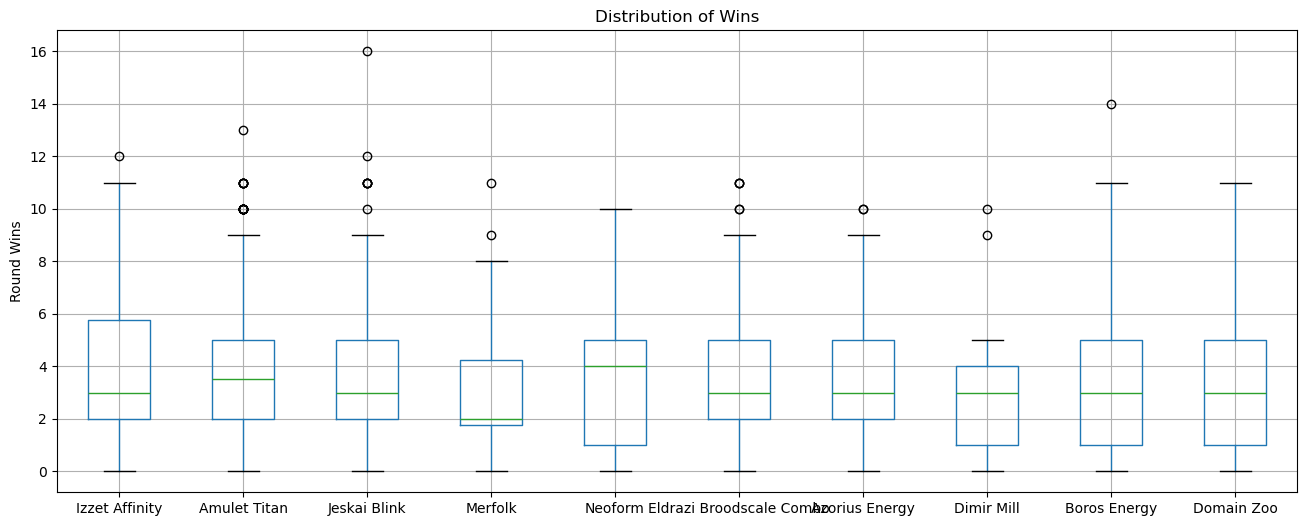

In [ ]:
complete_wins_per_deck[highest_winrate_decks].boxplot(figsize=(16,6))
plt.ylabel('Round Wins')
plt.title("Distribution of Wins")
#This graph shows the distribution of wins for the top 10 most winning decks.
# Outliers are very high finishes in tournaments. Outliers = GOOD if they are not too far from the edge of the boxplot ( greater than 10 )
# Comparing the last two strategies, boros energy and domain zoo, you can see that they are very similar in thier consistancy
# But boros energy has a higher finish. this could influence your descision since that strategy has proven itself in the past
# 

In [ ]:
try: # sets match record to numeric
    complete_participants["Match Record"] = complete_participants["Match Record"].apply(convert_stringlist_to_numeric)
except: # sets wins, loss and draw column in participants
    complete_participants["Wins"] = complete_participants["Match Record"].str[0]
    complete_participants["Loses"] = complete_participants["Match Record"].str[1]
    complete_participants["Draws"] = complete_participants["Match Record"].str[2]
def tournament_date(location_str: str):
    """Pulls out the date of the tournament from the folder name."""
    t_date = "-".join(location_str.split("_")[-3:])
    return pd.to_datetime(t_date)
try: #Sets date for each variable
    complete_participants["Date"] = complete_participants["Location"].apply(tournament_date)
    complete_rounds["Date"] = complete_rounds["Location"].apply(tournament_date)
    complete_decklists["Date"] = complete_decklists["Location"].apply(tournament_date)
except:
    pass

In [ ]:
#first thing is combine all_round_results and decklists so i can compare decklists
baltimore_round_decklists = pd.DataFrame(columns=["Round", "Winning Player Name","Winning Deck", "Losing Player Name", "Losing Deck"])
for ele in just_baltimore_rounds.values:
    for deck in deck_names:
        for player in just_baltimore_participants[just_baltimore_participants["Deck Name"] == deck]["Player Profile Name"].values:
            if ele[1] == 'Draw':
                break
            if player == ele[1]:
                winner = player
                winning_deck = deck
            if player == ele[3]:
                loser = player
                losing_deck = deck
    tournament_round = ele[0]
    try:
        baltimore_round_decklists.loc[len(baltimore_round_decklists)] = [tournament_round, winner,winning_deck,loser,losing_deck]
    except:
        print(ele)

[6 'Draw' 'MullMoney' 'Vinny2582' '0-0-3' 'rcq_baltimore_10_26_2025']
[6 'Draw' 'MangaEater' 'TerS1' '0-0-3' 'rcq_baltimore_10_26_2025']
[5 'Draw' 'JammerSoul' 'Kulozo' '1-1-0' 'rcq_baltimore_10_26_2025']
[2 'Draw' 'bel9ev' 'Parrotlet' '1-1-0' 'rcq_baltimore_10_26_2025']
[1 'Draw' 'carter01' 'bigstanno' '1-1-0' 'rcq_baltimore_10_26_2025']
[3 'Draw' 'GoldenCapitalist' 'keska' '0-0-3' 'rcq_baltimore_10_26_2025']


In [ ]:
#first thing is combine all_round_results and decklists so i can compare decklists
all_round_decklists = pd.DataFrame(columns=["Round", "Winning Player Name","Winning Deck", "Losing Player Name", "Losing Deck"])
#creates a dataframe with the round, the winner and thier deck and the loser and their deck
for ele in complete_rounds.values:
    for deck in deck_names:
        for player in complete_participants[complete_participants["Deck Name"] == deck]["Player Profile Name"].values:
            if ele[1] == 'Draw':
                break
            if player == ele[1]:
                winner = player
                winning_deck = deck
            if player == ele[3]:
                loser = player
                losing_deck = deck
    tournament_round = ele[0]
    try:
        all_round_decklists.loc[len(all_round_decklists)] = [tournament_round, winner,winning_deck,loser,losing_deck]
    except:
        print(ele)

Text(50.7222222222222, 0.5, 'Most Popular')

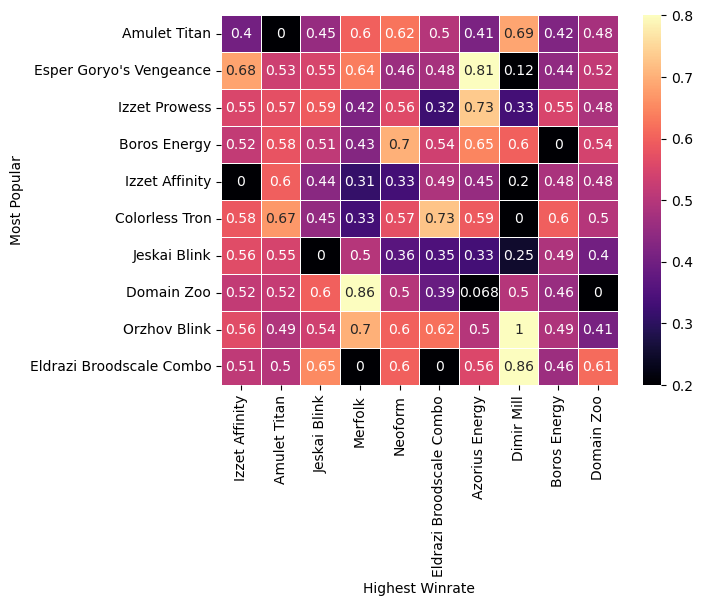

In [ ]:
# Lost to Amulet
deck_win_percentage = pd.DataFrame()
for deck in deck_names:
    try:
        wins = all_round_decklists[(all_round_decklists["Winning Deck"] == deck)].groupby('Losing Deck').size().drop(deck)
    except:
        wins = all_round_decklists[(all_round_decklists["Winning Deck"] == deck)].groupby('Losing Deck').size()
    try:
        loss = all_round_decklists[(all_round_decklists["Losing Deck"] == deck)].groupby('Winning Deck').size().drop(deck)
    except:
        loss = all_round_decklists[(all_round_decklists["Losing Deck"] == deck)].groupby('Winning Deck').size()
    total = pd.concat([loss, wins], axis=1).fillna(0)
    total['Total'] = total[0] + total[1]
    total[deck] = total[1]/total["Total"]
    total[total['Total'] > 2]
    deck_win_percentage = pd.concat([deck_win_percentage, total[deck]], axis=1).fillna(0)
sns.heatmap(deck_win_percentage.loc[most_popular_decks, highest_winrate_decks], cmap='magma', annot=True, linewidth=.5, vmin=.2, vmax=.8)
plt.xlabel('Highest Winrate')
plt.ylabel('Most Popular')